In [54]:
# Import needed packages for analysis
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.stats import pearsonr
from scipy.stats import kendalltau


import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV
import cfl.util.fear_mice_functions as fm 

behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'
mri_dir, mri_dims, affine, dir_labels = fm.get_global_values()

# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path, ori='RPS')
nolin_mask_vec = BU.flatten(nl_mask)

# load response data 
Y = pd.read_pickle('Y.pkl')

In [4]:
# load all the images in RPS orientation 
X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, ori='RPS')
data_id = 'X_'

# Variance
This plot shows the level of variance between individual voxels across all the MRIs

In [10]:
# create array showing overall variance 
var_all = np.zeros(np.prod(mri_dims))
var_all[...] = np.var(X, axis=0)

# BV.plot_interactive_panels(var_all, mri_dims, nolin_mask_vec, figsize=(8, 3), dir_labels=dir_labels, colormap="Reds", step= 1, column_titles=["Variance across all MRIs"]) 

In [22]:
# fm.save_as_nifti(var_all, os.path.join("correctly_oriented_niis", data_id + "var_all.nii"), mri_dims, affine)

# Calculate the variance for each timepoint

In [23]:
var_dir = fm.timepoint_indices_dir(Y)
for timepoint in var_dir: #iterate over each time point

    current_var = np.var(X[var_dir[timepoint]], axis=0)
    var_dir[timepoint] = current_var

# BV.plot_interactive_panels(np.vstack(var_dir.values()), mri_dims, nolin_mask_vec, figsize=(15, 5), dir_labels=dir_labels, colormap="Reds", step= 1, column_titles=["Baseline Variance", "Pre-fear Variance", "Fear Variance", "D9 Variance"]) 

 The variance tends to be highest on the edges of the brain or in small regions inside of the brain. I believe these regions correspond with the regions of high activity seen above in the individual MRIs. Some of these are due to edge of the brain effects. The variance seems to be fairly constant across mice. 

# Variance for each timepoint, for each genotype
This plot shows the level of variance between individual voxels in all the MRIs for each timepoint.

In [24]:
indices_dir = fm.geno_time_indices_dir(Y)

# make a new dict that has the variance array for each keys value 
var_dir = fm.empty_geno_time_dir(Y, mri_dims)
for group in indices_dir: 
    current_var = np.var(X[indices_dir[group]], axis=0)
    var_dir[group] = current_var


# BV.plot_interactive_panels(np.vstack(var_dir.values())[:4], mri_dims, nolin_mask_vec, figsize=(15, 3), dir_labels=dir_labels, colormap="Reds", column_titles=list(var_dir.keys())[:4]) 

In [25]:
# BV.plot_interactive_panels(np.vstack(var_dir.values())[4:], mri_dims, nolin_mask_vec, figsize=(15, 3), dir_labels=dir_labels, colormap="Reds", column_titles=list(var_dir.keys())[4:]) 

# Identify highest variance locations

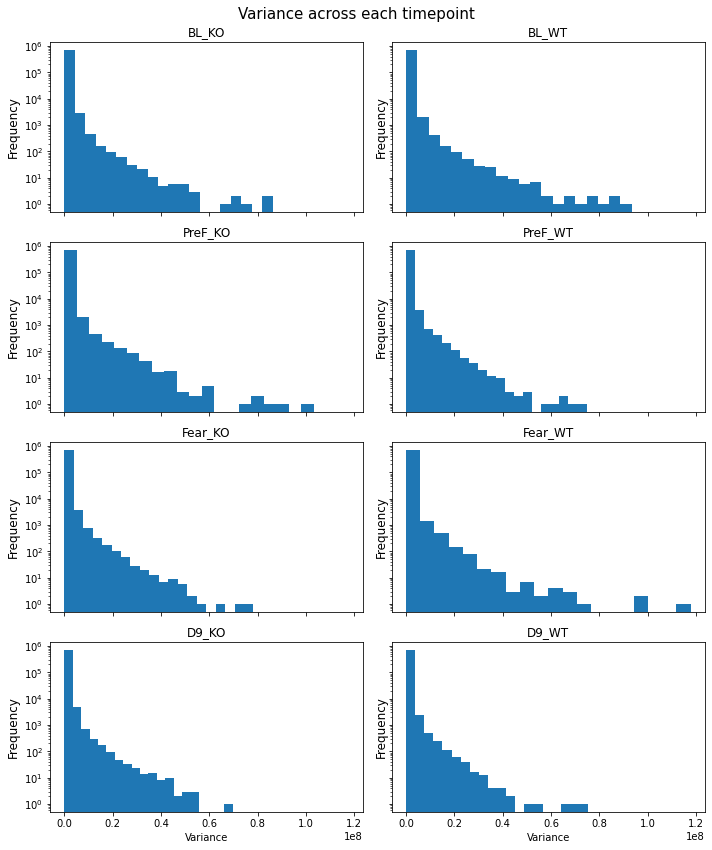

In [26]:
#variance histograms 
# full_name = {"BL": "baseline", "PreF": "Before fear experience", "Fear": "Fear experience", "D9": "9 days after fear experience"}

fig, ax = plt.subplots(nrows=4, ncols=2, squeeze=False, figsize=(10, 12), sharex=True, sharey=True)
fig.suptitle("Variance across each timepoint", fontsize=15)
timepoints = var_dir.keys()
for n, timepoint in enumerate(timepoints):
    col = n % 2
    row = int(n / 2)
    # use masked array to exclude variances equal to 0 
    a = np.ma.masked_equal(var_dir[timepoint],0)
    ax[row, col].hist(a.compressed(), bins=20)
    ax[row, col].title.set_text(timepoint)
    ax[row, col].set_ylabel("Frequency", fontsize=12)

plt.yscale('log')

ax[3, 1].set_xlabel("Variance")
ax[3, 0].set_xlabel("Variance")
plt.tight_layout()
plt.show()   

# plot histogram of the variance at each genotype/timepoint (excluding 0 variances)
# y is graphed on a log scale 

In [14]:
# mask the portions of the mris where the variance equals 0 
# (ie the voxels that are outside the brain area)
# done because the majority of voxels have 0 variance and we want 
# to disregard all of those in the calculations of percentile 
var_all_no0 = np.ma.masked_equal(var_all,0).compressed()

In [15]:
# calculate the amount of variance that corresponds to each possible percentile 
# (percentiles go from 0 to 100 inclusive)
all_thresholds = np.percentile(var_all_no0, list(range(0, 101)))

# now find which variance percentile that each voxel corresponds to
var_percentiles = np.searchsorted(all_thresholds, var_all)

In [29]:
# BV.plot_interactive_panels(var_percentiles, mri_dims, nolin_mask_vec, figsize=(12, 5), dir_labels=dir_labels, column_titles=["Variance percentile for each voxel"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

## Visualize highest variance regions only

In [30]:
# graph the top 5 percentiles for each image 
var_percentiles_top_5 = var_percentiles.copy()
var_percentiles_top_5[var_all < np.percentile(var_all, 95)] = 5

# BV.plot_interactive_panels(var_percentiles_top_5, mri_dims, nolin_mask_vec, figsize=(8, 3), dir_labels=dir_labels, column_titles=["Location of top 5% variance voxels"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

In [31]:
# graph the top 1 percentiles for each image 
var_percentiles_top_1 = var_percentiles.copy()
var_percentiles_top_1[var_all < np.percentile(var_all, 99)] = 5

# BV.plot_interactive_panels(var_percentiles_top_1, mri_dims, nolin_mask_vec, figsize=(8, 3), dir_labels=dir_labels, column_titles=["Location of top 1% variance voxels"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

In [25]:
# graph the top 3 percentiles for each image 
var_percentiles_top_3 = var_percentiles.copy()
var_percentiles_top_3[var_percentiles < 97] = 5

# BV.plot_interactive_panels(var_percentiles_top_1, mri_dims, nolin_mask_vec, figsize=(8, 3), dir_labels=dir_labels, column_titles=["Location of top 3% variance voxels"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

conclusions: 
-  high variance in many places tends to concentrate around the edges of the brain (54)
- seems like knocking out high variance will get rid of the really high activity spots ? (60 ish)
- Note that those inward cutting chunks (like in slice 64) look like they're not on the edge of the brain, but they acually are due to the way the brain folds in 

# Remove voxels with the top 3% variance

In [11]:
# remove items with top 3% of variance from X 
X_var3 = X.copy()
X_var3[X > np.percentile(var_all, 97)] = 0

np.save(os.path.join('npy_files', str(data_id) + "var3.npy"), X_var3)


## Visualize the heatmaps without the highest 3% variance voxels

In [61]:
# create a mask to block out top 3% of variance
low_var_mask = np.where(var_percentiles_top_3 >= 97, 0, 1)
low_var_mask = np.multiply(low_var_mask, nolin_mask_vec)


In [62]:
# load heatmaps for each genotype, timepoint 
all_HM_dir = fm.empty_geno_time_dir(Y, mri_dims)
for key in all_HM_dir: 
    all_HM_dir[key] = np.load(os.path.join('npy_files', data_id + 'heatmap_' + key + '.npy'))
    
    
bl_and_pref, bl_and_pref_names = fm.select_from_dict(all_HM_dir, ['BL', 'PreF'])


#display BL and pre-fear heatmaps 
# BV.plot_interactive_panels(bl_and_pref, mri_dims, low_var_mask, figsize=(17, 3), dir_labels=dir_labels, column_titles=bl_and_pref_names)

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

In [64]:
# #display fear and d9 heatmaps 
# fear_and_d9, fear_and_d9_names = fm.select_from_dict(all_HM_dir, ['Fear', 'D9'])


# BV.plot_interactive_panels(fear_and_d9, mri_dims, low_var_mask, figsize=(17, 3), dir_labels=dir_labels, column_titles=fear_and_d9_names)

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

In [69]:
# save the mask 
# name = 'mask_' + data_id + 'without_top3_var'
np.save(os.path.join('npy_files', name+'.npy'), low_var_mask)
fm.save_as_nifti(low_var_mask, os.path.join('correctly_oriented_niis', name), mri_dims, affine)